/var/folders/54/7byrywl93ynbd42k_q4n9b6w0000gn/T/ipykernel_26415/3734799103.py:129: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  clear_events_by_cell = grp.apply(lambda g: g.loc[g[COL_CLEAR_ENG], COL_EVENT_ID].nunique()).to_dict()
/var/folders/54/7byrywl93ynbd42k_q4n9b6w0000gn/T/ipykernel_26415/3734799103.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(cells))


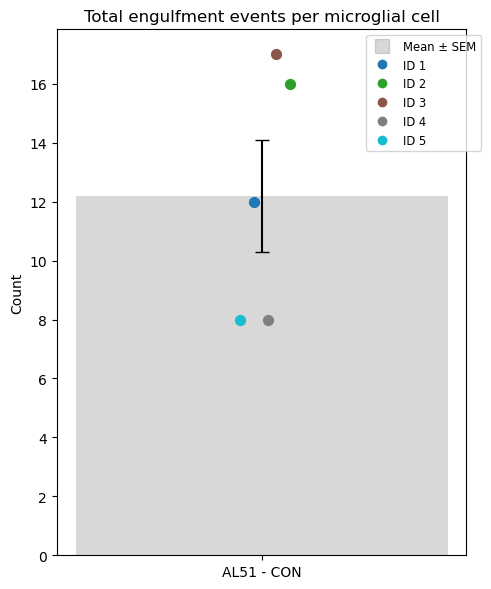

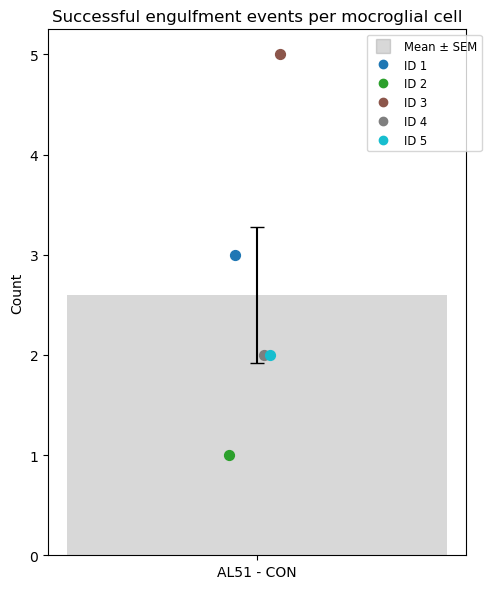

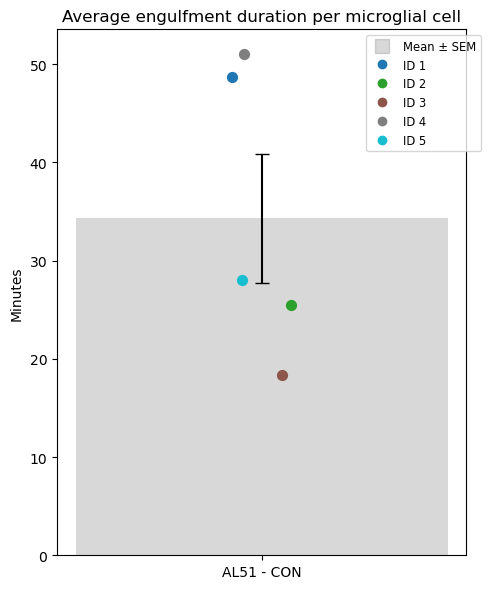

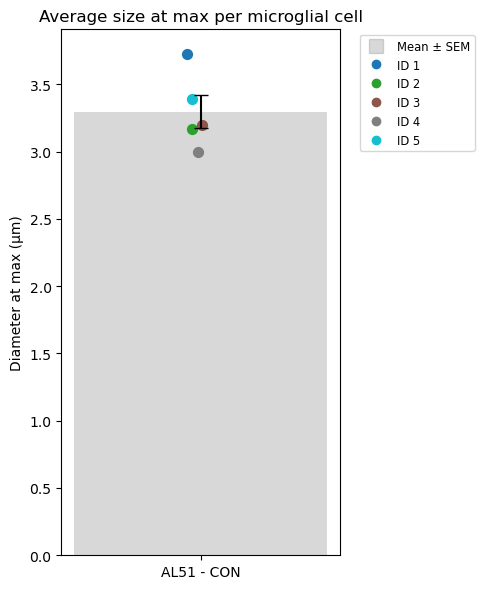

In [5]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

# === User-defined parameters ===
FILE_PATH          = "/Users/alexlawson/Masters-Data-Final/Live-imaging/Results/al51.csv"
TIME_PER_FRAME     = 8.0     # minutes per frame (set to your imaging rate)
INCLUSIVE_FRAMES   = False   # 10-11 -> 1 frame => exclusive
XTICK_LABEL        = "AL51 - CON"   # label under the single bar
SAVE_PATH_BASE     = None    # e.g., "/path/to/output.png" (we append suffixes), or None to just show

# CSV column names (keep as-is if your file uses these headers)
COL_CELL_ID        = "Cell ID"
COL_EVENT_ID       = "Event ID"
COL_FRAME_START    = "Frame Start"
COL_FRAME_END      = "Frame End"
COL_SIZE_MAX       = "Size at max"
COL_CLEAR_ENG      = "Clear engulfment"

# make jitter reproducible (optional)
np.random.seed(42)

def normalize_clear_flag(s: pd.Series) -> pd.Series:
    """Map Clear engulfment to boolean."""
    if s.dtype == bool:
        return s
    mapping = {
        "true": True, "t": True, "yes": True, "y": True, "1": True, "clear": True,
        "false": False, "f": False, "no": False, "n": False, "0": False, "unclear": False
    }
    def to_bool(x):
        if pd.isna(x): return False
        if isinstance(x, (int, float, np.integer, np.floating)): return bool(int(x))
        return mapping.get(str(x).strip().lower(), False)
    return s.apply(to_bool)

def duration_minutes(df: pd.DataFrame) -> pd.Series:
    """Compute event duration in minutes from frame indices."""
    frames = df[COL_FRAME_END].astype(float) - df[COL_FRAME_START].astype(float)
    if INCLUSIVE_FRAMES:
        frames = frames + 1.0
    frames = frames.where(frames >= 0, np.nan)
    return frames * TIME_PER_FRAME

def one_bar_with_jitter(values_by_cell, xtick_label, y_label, title, color_dict, save_suffix=None):
    """Plot single mean±SEM bar with jittered per-cell points colored by cell ID."""
    # pack into DataFrame to keep order stable
    df_plot = pd.DataFrame({
        "Cell": list(values_by_cell.keys()),
        "Value": list(values_by_cell.values())
    })
    overall_mean = df_plot["Value"].mean()
    overall_sem  = df_plot["Value"].std(ddof=1) / np.sqrt(len(df_plot))

    fig, ax = plt.subplots(figsize=(5,6))
    bar_center = 1.0
    bar_width  = 0.3

    # mean ± SEM bar
    ax.bar(
        bar_center, overall_mean,
        width=bar_width,
        yerr=overall_sem,
        capsize=5,
        alpha=0.3,
        color='grey',
        label='Mean ± SEM'
    )

    # jittered points inside the bar
    x_jitter = bar_center + np.random.uniform(-bar_width/12, bar_width/12, size=len(df_plot))
    for i, row in df_plot.iterrows():
        ax.scatter(
            x_jitter[i],
            row["Value"],
            color=color_dict[row["Cell"]],
            s=50
        )

    ax.set_xticks([bar_center])
    ax.set_xticklabels([xtick_label])
    ax.set_ylabel(y_label)
    ax.set_title(title)

    # legend: mean + each cell color
    handles = [
        plt.Line2D([0],[0], marker='s', color='grey', label='Mean ± SEM',
                   alpha=0.3, markersize=10, linestyle='None')
    ] + [
        plt.Line2D([0],[0], marker='o', color=color_dict[cid], label=f'ID {cid}',
                   markersize=6, linestyle='None') for cid in df_plot["Cell"]
    ]
    ax.legend(handles=handles, bbox_to_anchor=(1.05,1), fontsize='small')
    plt.tight_layout()

    # save or show
    if SAVE_PATH_BASE:
        base, ext = os.path.splitext(SAVE_PATH_BASE)
        ext = ext if ext else ".png"
        out = f"{base}_{save_suffix}{ext}" if save_suffix else f"{base}{ext}"
        fig.savefig(out, dpi=300)
        print(f"Saved: {out}")
    else:
        plt.show()

def plot_phagocytosis_metrics():
    # 1) Load
    df = pd.read_csv(FILE_PATH)

    required = [COL_CELL_ID, COL_EVENT_ID, COL_FRAME_START, COL_FRAME_END, COL_SIZE_MAX, COL_CLEAR_ENG]
    missing  = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}. Found: {list(df.columns)}")

    # 2) Clean / compute event-level fields
    df = df.copy()
    df[COL_CLEAR_ENG] = normalize_clear_flag(df[COL_CLEAR_ENG])
    df["Duration (min)"] = duration_minutes(df)
    df[COL_SIZE_MAX] = pd.to_numeric(df[COL_SIZE_MAX], errors="coerce")

    # 3) Per-cell aggregates (event-level -> cell)
    # Use nunique on Event ID to avoid double counting if multiple rows per event exist.
    grp = df.groupby(COL_CELL_ID, dropna=False)

    total_events_by_cell = grp[COL_EVENT_ID].nunique().to_dict()
    clear_events_by_cell = grp.apply(lambda g: g.loc[g[COL_CLEAR_ENG], COL_EVENT_ID].nunique()).to_dict()
    avg_dur_by_cell      = grp["Duration (min)"].mean().to_dict()      # NaNs skipped
    avg_size_by_cell     = grp[COL_SIZE_MAX].mean().to_dict()          # NaNs skipped

    #OLD COLOR SCHEME
   # cells = sorted(total_events_by_cell.keys(), key=lambda x: (str(x)))
   # cmap = plt.cm.get_cmap('rainbow', len(cells))  # evenly spaced colors from red to violet
  #  color_dict = {cid: cmap(i) for i, cid in enumerate(cells)}

    # What I want: Create a consistent color map for MicrogliaID
    cells = sorted(df['Cell ID'].unique())
    cmap = plt.cm.get_cmap('tab10', len(cells))
    color_dict = {mid: cmap(i) for i, mid in enumerate(cells)}
    

    # 5) Plots (one bar + jittered per-cell points), matching your style
    one_bar_with_jitter(
        {cid: total_events_by_cell[cid] for cid in cells},
        XTICK_LABEL, "Count", "Total engulfment events per microglial cell",
        color_dict, save_suffix="total_events"
    )

    one_bar_with_jitter(
        {cid: clear_events_by_cell[cid] for cid in cells},
        XTICK_LABEL, "Count", "Successful engulfment events per mocroglial cell",
        color_dict, save_suffix="clear_events"
    )

    one_bar_with_jitter(
        {cid: avg_dur_by_cell[cid] for cid in cells},
        XTICK_LABEL, "Minutes", "Average engulfment duration per microglial cell",
        color_dict, save_suffix="avg_duration"
    )

    one_bar_with_jitter(
        {cid: avg_size_by_cell[cid] for cid in cells},
        XTICK_LABEL, "Diameter at max (µm)", "Average size at max per microglial cell",
        color_dict, save_suffix="avg_size"
    )

if __name__ == "__main__":
    plot_phagocytosis_metrics()
